In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import random
import matplotlib.pyplot as plt

In [2]:
seed = 2024
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device is {device}')

device is cuda


In [3]:
# Data Aumgentation - Train Data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True,
                                 transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True,
                                transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [5]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=2)
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, 10)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [8]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [9]:
model = ResNet18().to(device)
num_epochs = 50
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3) # L2 regularization 적용
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# conv layer weight 개수 출력
total_weights = sum(p.numel() for p in model.parameters() if p.requires_grad and p.dim() > 1)
print("Total weights (excluding biases):", total_weights)

In [10]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    total = 0
    correct = 0
    train_loss = 0.0

    # train
    model.train()
    print(f'   Epoch [{epoch+1}/{num_epochs}]')
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total

    # validation
    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(validation_loader)
    val_accuracy = 100. * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


    print(f'Train Loss: {train_loss:.4f}')
    print(f'  Val_Loss: {val_loss:.4f}')
    print(f' Train_acc: {train_accuracy:.2f}%')
    print(f'   Val_acc: {val_accuracy:.2f}%\n')

    scheduler.step()

   Epoch [1/50]
Train Loss: 1.5672
  Val_Loss: 1.3604
 Train_acc: 42.14%
   Val_acc: 49.43%

   Epoch [2/50]
Train Loss: 1.1474
  Val_Loss: 1.1542
 Train_acc: 58.43%
   Val_acc: 58.46%

   Epoch [3/50]
Train Loss: 0.9723
  Val_Loss: 1.0277
 Train_acc: 65.42%
   Val_acc: 64.95%

   Epoch [4/50]
Train Loss: 0.8521
  Val_Loss: 0.8300
 Train_acc: 70.09%
   Val_acc: 71.24%

   Epoch [5/50]
Train Loss: 0.7616
  Val_Loss: 0.8754
 Train_acc: 73.72%
   Val_acc: 69.61%

   Epoch [6/50]
Train Loss: 0.6789
  Val_Loss: 0.9245
 Train_acc: 76.77%
   Val_acc: 68.12%

   Epoch [7/50]
Train Loss: 0.6278
  Val_Loss: 0.6755
 Train_acc: 78.38%
   Val_acc: 76.48%

   Epoch [8/50]
Train Loss: 0.5814
  Val_Loss: 0.6024
 Train_acc: 80.20%
   Val_acc: 79.22%

   Epoch [9/50]
Train Loss: 0.5372
  Val_Loss: 0.5936
 Train_acc: 81.80%
   Val_acc: 80.21%

   Epoch [10/50]
Train Loss: 0.5073
  Val_Loss: 0.6232
 Train_acc: 82.89%
   Val_acc: 78.57%

   Epoch [11/50]
Train Loss: 0.4788
  Val_Loss: 0.5951
 Train_acc: 83

In [11]:
# test
correct = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100.* correct / len(test_loader.dataset):.2f} %')

Test Accuracy: 91.53 %


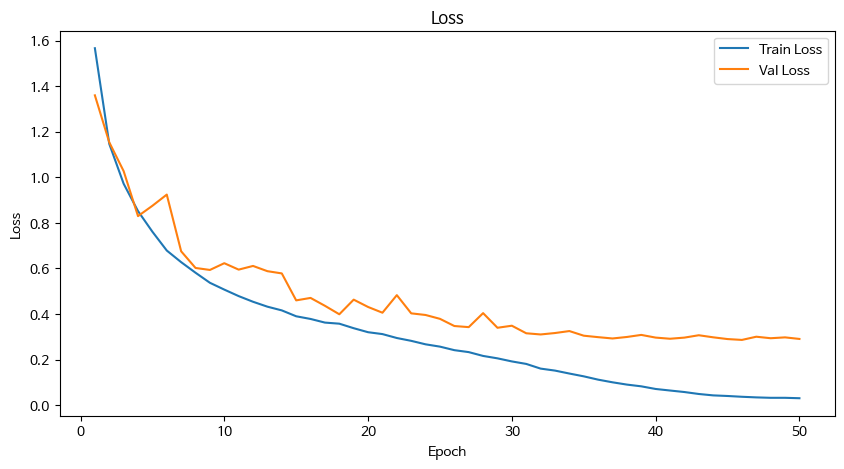

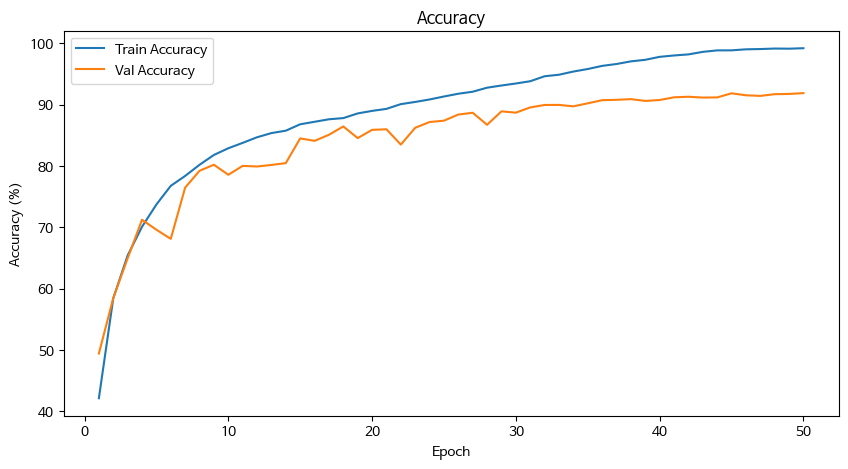

In [12]:
# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.show()